In [1]:
import geopandas
import leafmap
import geoplot
import geoplot.crs as gcrs
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta

This file is used to convert data from excel format to geopandas dataframe. The notebook contains also some plots and analysis of the data.

In [2]:
aoi_dir = "data/aoi.geojson"
points = "data/measurements/shp_GA_5513_1739_2022/GA_5513_1739_2022_punkty_czynne_i_archiwalne_m_ilosc_i_bad.shp"

In [3]:
geodf = geopandas.read_file(aoi_dir)
points_df = geopandas.read_file(points)
points_df = points_df.set_crs("EPSG:2180")
points_df = points_df.to_crs("EPSG:4326")
points_df['geometry'] = points_df['geometry'].explode(index_parts=False)

In [4]:
points_df.head(2)

,ID,NR_M_ILOSC,RZAD,NR_OTW_W_S,CZYNNY,ROK_ZAKONC,NR_M_BADAW,WOJ_NAZWA,POW_NAZWA,GM_NAZWA,M_NAZWA,GMRotation,geometry
0,161,126.0,II,1.0,0,1989-01-01,NaN,l¹skie,bielski,Buczkowice,Zawodzie,0.000000e+00,POINT (19.17842 50.72782)
1,395,472.0,II,1.0,0,2016-01-01,NaN,l¹skie,k³obucki,Wrêczyca Wielka,Golce,5.336085e-07,POINT (18.87222 50.85889)


<GeoAxesSubplot:>

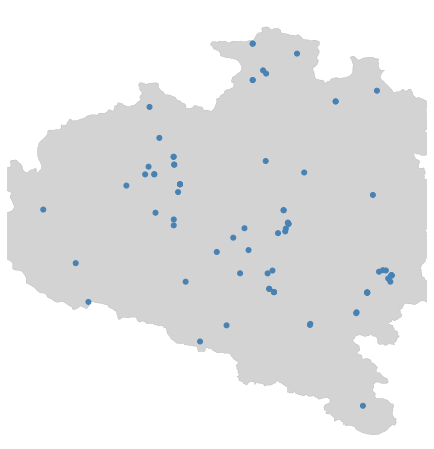

In [5]:
ax = geoplot.polyplot(geodf, projection=gcrs.AlbersEqualArea(), edgecolor='darkgrey', facecolor='lightgrey', linewidth=.3,
    figsize=(12, 8))
geoplot.pointplot(points_df, ax=ax)

In [6]:
def excel_to_geopandas(excel_data_dir, points_data_dir):
    excel_data = pd.read_excel(excel_data_dir)
    excel_data = excel_data.drop(excel_data.index[0])
    excel_data.columns = excel_data.iloc[0]
    excel_data = excel_data.drop(excel_data.index[0])
    excel_data.reset_index(inplace=True)
    excel_data.drop("index", inplace=True, axis=1)
    excel_data = excel_data.rename(columns = {"Data/Punkty": "date"})

    excel_data["date"] = pd.to_datetime(excel_data["date"], format='%Y-%m-%d %H:%M:%S')
    excel_data[excel_data.loc[:, excel_data.columns != "date"].columns] = excel_data[excel_data.loc[:, excel_data.columns != "date"].columns].astype('float64')
    excel_data_melted = excel_data.melt(id_vars=["date"],
                             var_name="name",
                             value_name="value")
    points_data = pd.read_excel(points_data_dir)
    points_data = points_data[["Numer punktu monitoringu stanu ilościowego", "Rzędna terenu [m n.p.m.]", "Współrzędne PUWG 1992 X", "Współrzędne PUWG 1992 Y"]]
    points_data = points_data.rename(columns = {"Numer punktu monitoringu stanu ilościowego": "name", "Rzędna terenu [m n.p.m.]": "height", "Współrzędne PUWG 1992 X": "longitude", "Współrzędne PUWG 1992 Y": "latitude"}) 
    data_merged = pd.merge(excel_data_melted, points_data, on="name")
    data_merged["normalized_value"] = data_merged["height"] - data_merged["value"] 
    gdf = geopandas.GeoDataFrame(data_merged, geometry=geopandas.points_from_xy(data_merged.longitude, data_merged.latitude))
    
    gdf = gdf.set_crs("EPSG:2180")
    gdf = gdf.to_crs("EPSG:4326")
    gdf = gdf.drop(["longitude", "latitude"], axis=1)
    return gdf
    

In [7]:
excel_data_dirs = ["data/measurements/GA_5513_1739_2022_monitoring_st_ilosciowego_pomiary_manualne.xls", "data/measurements/GA_5513_1739_2022_monitoring_st_ilosciowego_pomiary_automatyczne.xls"]
excel_data_geojson_dirs = ["data/measurements/GA_5513_1739_2022_quantitative_status_monitoring_manual.json", "data/measurements/GA_5513_1739_2022_quantitative_status_monitoring_automatic.json"]
excel_data = pd.read_excel(excel_data_dirs[0])
excel_data.head()

,głębokość zwierciadła wody od powierzchni terenu [m] lub wydajność [/s],Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,NaN,[m],[m],[m],[m],[m],[m],[m],[m],[m],...,[m],[m],[m],[m],[m],[m],[m],[m],[m],[m]
1,Data/Punkty,II/112/1,II/113/1,II/114/1,II/115/1,II/116/1,II/131/1,II/132/1,II/292/1,II/297/1,...,II/936/1,II/940/1,II/949/1,II/951/1,II/952/1,II/957/1,II/1345/1,II/1346/1,II/1351/1,II/1352/1
2,2001-11-05 00:00:00,9.65,31.96,29.35,10.58,8.25,16.86,48.15,12.07,5.1,...,0.17,42.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2001-11-12 00:00:00,9.66,31.91,29.44,10.57,8.19,16.96,48.25,12.05,5.2,...,0.16,42.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2001-11-19 00:00:00,9.66,31.86,29.3,10.55,8.11,16.91,48.2,12.08,5.2,...,0.2,42.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
points_data_dir = "data/measurements/GA_5513_1739_2022_dane_o_punktach_czynnych_i_archiwalnych.xls"

In [9]:
#Uncomment to generate geojson files
#for i, excel_data in enumerate(excel_data_dirs):
#    gdf = excel_to_geopandas(excel_data, points_data_dir)
#    gdf.to_file(excel_data_geojson_dirs[i], driver="GeoJSON")

In [10]:
gdf_manual = excel_to_geopandas(excel_data_dirs[0], points_data_dir)
gdf_auto = excel_to_geopandas(excel_data_dirs[1], points_data_dir)

gdf_manual = gdf_manual.dropna()
gdf_auto = gdf_auto.dropna()

        
    

Some plots & correlation matrix

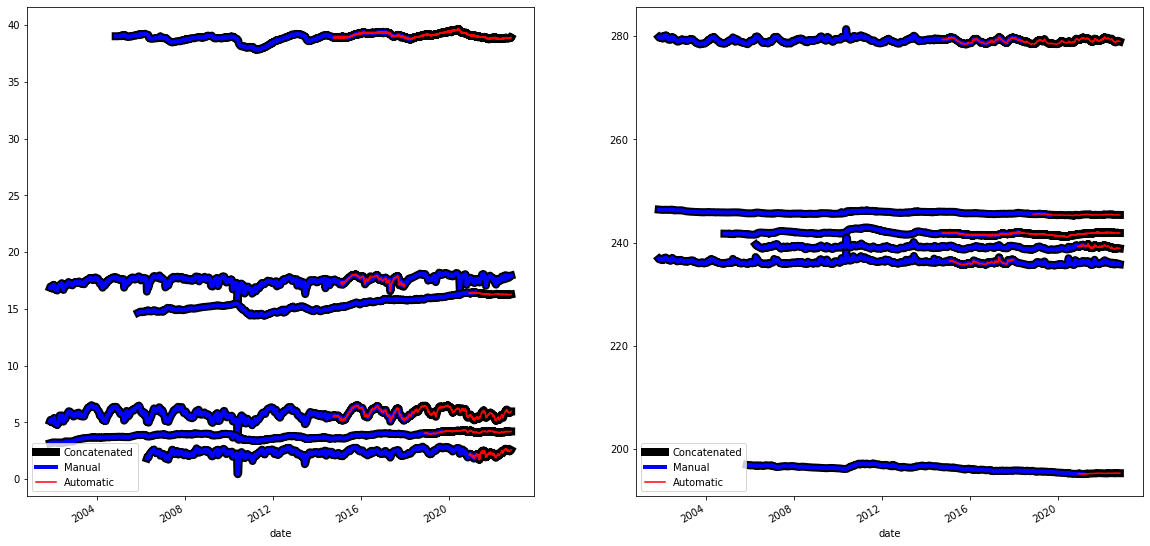

In [19]:
#auto stations are continuation of manual stations
plt.rcParams["figure.figsize"] = (20,10)
fig, axs = plt.subplots(1, 2)
ax = axs[0]
for name in gdf_auto['name'].unique():
    gdf[gdf['name'] == name].plot(kind='line',x='date',y='value',ax=ax, c="black", label="Concatenated", style='-', linewidth=8)
    gdf_manual[gdf_manual['name'] == name].plot(kind='line',x='date',y='value', c="blue", ax=ax, label="Manual", style='-', linewidth=4)
    gdf_auto[gdf_auto['name'] == name].plot(kind='line',x='date',y='value',ax=ax, c="red", label="Automatic", style='-')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

ax = axs[1]
for name in gdf_auto['name'].unique():
    gdf[gdf['name'] == name].plot(kind='line',x='date',y='normalized_value',ax=ax, c="black", label="Concatenated", style='-', linewidth=8)
    gdf_manual[gdf_manual['name'] == name].plot(kind='line',x='date',y='normalized_value', c="blue", ax=ax, label="Manual", style='-', linewidth=4)
    gdf_auto[gdf_auto['name'] == name].plot(kind='line',x='date',y='normalized_value',ax=ax, c="red", label="Automatic", style='-')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

plt.show()

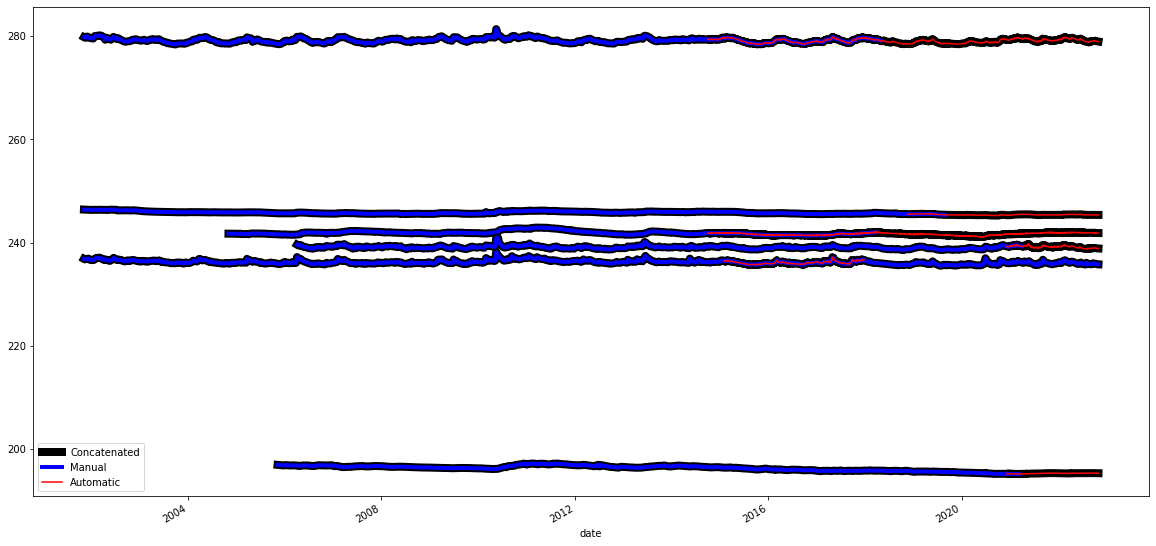

In [29]:
fig, ax = plt.subplots()
for name in gdf_auto['name'].unique():
    gdf[gdf['name'] == name].plot(kind='line',x='date',y='normalized_value',ax=ax, c="black", label="Concatenated", style='-', linewidth=8)
    gdf_manual[gdf_manual['name'] == name].plot(kind='line',x='date',y='normalized_value', c="blue", ax=ax, label="Manual", style='-', linewidth=4)
    gdf_auto[gdf_auto['name'] == name].plot(kind='line',x='date',y='normalized_value',ax=ax, c="red", label="Automatic", style='-')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())
plt.show()

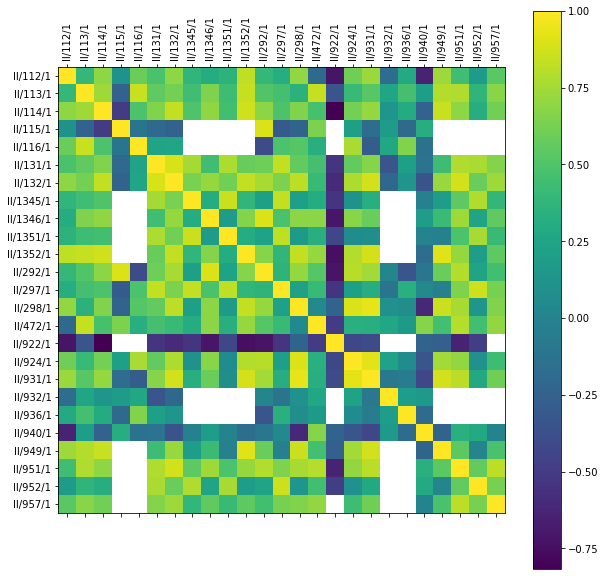

In [31]:
corr = gdf.set_index('date')
corr = corr.pivot(columns='name', values='normalized_value')
corr = corr.corr()
#plot correlation matrix
plt.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()

In [32]:
m = leafmap.Map()
m.add_gdf(gdf.drop(["date", "value"], axis=1).drop_duplicates(subset="geometry", keep="first"), layer_name="Stations", info_mode="on_click")
m.add_geojson("data/aoi.geojson", layer_name="AOI", info_mode="on_click")
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…